(537, 691, 3)


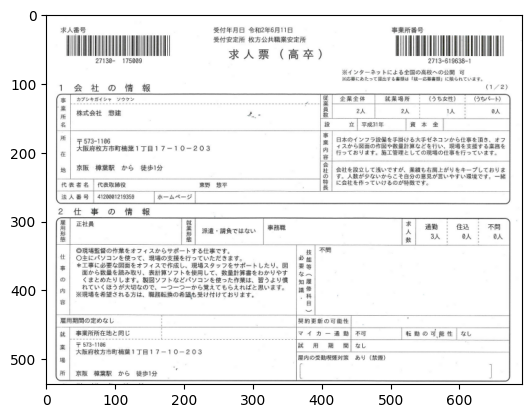

In [45]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

root_path = os.getcwd()
img_path = root_path+"/configs/image.png"
input_img = cv2.imread(img_path)
print(input_img.shape)
plt.imshow(input_img)

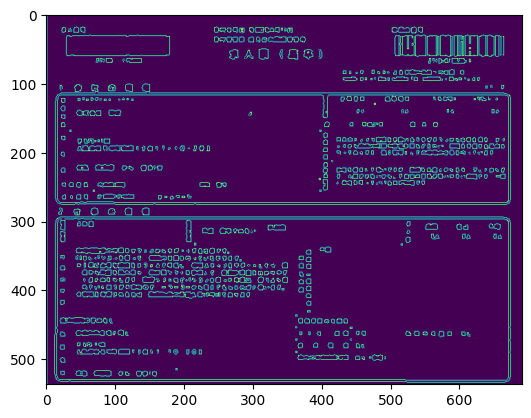

In [46]:

img = input_img.copy()

# Convert to Gray
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Make GaussianBlur (Normalized the colors)
blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

# Perform Thresholding (Weak lines are disappeared)
thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1]

# Perform Bilateral Filter
gray = cv2.bilateralFilter(thresh, 1, 100, 150)

# Perform Canny Edges Detections (Clear lines are become more clear)
imgThreshold = cv2.Canny(gray, 20, 250)



plt.imshow(imgThreshold)


In [47]:
def reorder(myPoints):
    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = myPoints.sum(1)

    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] = myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]

    return myPointsNew


##### What are contours?
Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.

[[[ 14 299]]

 [[ 18 532]]

 [[673 529]]

 [[668 295]]]

[[[ 16 124]]

 [[ 20 273]]

 [[671 271]]

 [[666 117]]]



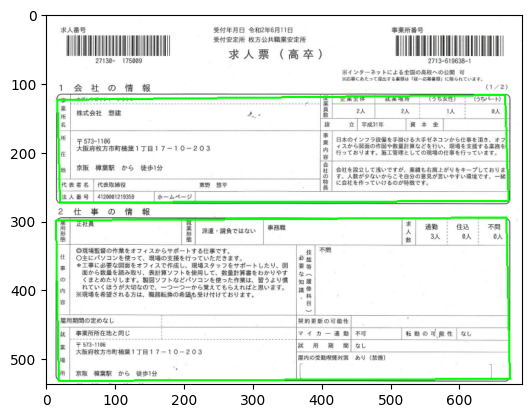

In [48]:

# FIND ALL CONTOURS
contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

rgb = img.copy()
rect_list = []

for i in contours:
    area = cv2.contourArea(i)

    if area > 8000:
        peri = cv2.arcLength(i, True)

        approx = cv2.approxPolyDP(i, 0.02 * peri, True)
        if len(approx) == 4:

            cv2.drawContours(rgb, [approx], -1, (0, 255, 0), 2)
            print(approx[:4])
            print()
            rect_list.append(reorder(approx[:4]))
plt.imshow(rgb)

True

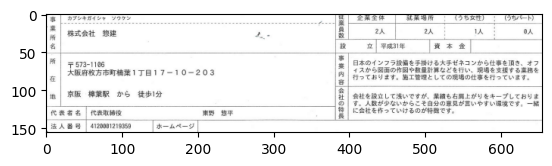

In [49]:
crop_img = img.copy()

i = 1

rect_result = rect_list

xindexs = [rect_result[i][0][0][0], rect_result[i][1][0][0], rect_result[i][2][0][0],
                rect_result[i][3][0][0]]

yindexs = [rect_result[i][0][0][1], rect_result[i][1][0][1], rect_result[i][2][0][1],
                rect_result[i][3][0][1]]


y1 = np.min(yindexs)
y2 = np.max(yindexs)
x1 = np.min(xindexs)
x2 = np.max(xindexs)


cropped_img = crop_img[y1:y2,x1:x2,:]
plt.imshow(cropped_img)


#Save image
cv2.imwrite("configs/block_1.png",cropped_img)

1. Create GCP account and Enable Vertex AI API and Cloud Vision API
2. Create service account with only Enable Vertex AI API user.
3. Download and add to cred

In [50]:
#!pip install python-dotenv
#!pip install google-cloud-vision

In [51]:
from dotenv import load_dotenv
print(load_dotenv())
print(os.getenv('GOOGLE_APPLICATION_CREDENTIALS'))


True
/Users/tharhtet/Documents/github/ML-in-Prod-batch-2/3_Image_Processing_Techniques/OCR_proj/credentials/service_account.json


In [78]:
img_path="configs/block_1.png"
#img_path="templates/block_1.jpg"

In [79]:


import io
from  google.cloud  import  vision
client = vision.ImageAnnotatorClient()
with io.open(img_path, 'rb') as image_file:
    content = image_file.read()

image = vision.Image(content=content)


In [80]:
response = client.text_detection(image=image)
response

text_annotations {
  locale: "ja"
  description: "カブシキガイシャ ソウケン\n株式会社 惣建\n所\n名\n所\n〒573-1106\n大阪府枚方市町楠葉1丁目17-10-203\n在\n地\n京阪 樟葉駅 から 徒歩1分\n代表者名 代表取締役\n法人番号\n4120001219359\n東野想平\nホームページ\n企業全体\n就菜場所\n2人\n2人\n(うち女性)\n人\n(うちパート)\n0人\n設\n立平成31年\n資本金\n従業員数 事内容 会社の特長\n日本のインフラ設備を手掛ける大手ゼネコンから仕事を頂き、 オフ\nィスから図面の作図や数量計算などを行い、 現場を支援する業務を\n内行っております。 施工管理としての現場の仕事を行っています。\n会社を設立して浅いですが、 業績も右肩上がりをキープしておりま\nす。人数が少ないからこそ自分の意見が言いやすい環境です。 一緒\nに会社を作っていけるのが特徴です。"
  bounding_poly {
    vertices {
      x: 4
    }
    vertices {
      x: 651
    }
    vertices {
      x: 651
      y: 152
    }
    vertices {
      x: 4
      y: 152
    }
  }
}
text_annotations {
  description: "カブシキガイシャ"
  bounding_poly {
    vertices {
      x: 28
      y: 3
    }
    vertices {
      x: 78
      y: 3
    }
    vertices {
      x: 78
      y: 10
    }
    vertices {
      x: 28
      y: 10
    }
  }
}
text_annotations {
  description: "ソウケン"
  bounding_poly {
    vertices {
      x: 84
      y: 3
    }
    vertices {
      x

In [81]:
import json
def load_template_frame(jsonTemplate_path):


    block_shapes = None
    template_infos = []

    with open(jsonTemplate_path, 'r') as json_file:
        data = json.load(json_file)
        block_shapes = data['shapes']

    for cur_bk in (block_shapes):
        label = cur_bk['label']
        points = cur_bk['points']
        x, y, x2, y2 = int(points[0][0]), int(points[0][1]), int(points[1][0]), int(points[1][1])

        template_infos.append([label, x, y, x2, y2])
    return template_infos



jsonTemplate_path = os.getcwd()+"/templates/block_1.json"
template_infos = load_template_frame(jsonTemplate_path)
print(template_infos)

[['1b_01', 1, 0, 47, 110], ['1b_02', 47, 0, 874, 31], ['1b_03', 48, 30, 872, 110], ['1b_04', 874, 2, 912, 76], ['1b_05', 910, 1, 1053, 31], ['1b_06', 911, 30, 1054, 75], ['1b_07', 1055, 1, 1201, 31], ['1b_08', 1054, 32, 1201, 75], ['1b_09', 1203, 1, 1349, 32], ['1b_10', 1203, 32, 1348, 77], ['1b_11', 1349, 0, 1498, 31], ['1b_12', 1498, 77, 1349, 30], ['1b_13', 874, 75, 995, 114], ['1b_14', 998, 75, 1158, 111], ['1b_15', 1158, 75, 1279, 112], ['1b_16', 1280, 76, 1498, 114], ['1b_17', 0, 109, 46, 259], ['1b_18', 47, 110, 873, 262], ['1b_19', 912, 207, 874, 113], ['1b_20', 914, 113, 1498, 208], ['1b_21', 873, 208, 911, 299], ['1b_22', 912, 207, 1498, 301], ['1b_23', 1, 259, 122, 297], ['1b_24', 124, 261, 872, 300], ['1b_25', 1, 297, 123, 334], ['1b_26', 123, 297, 323, 335], ['1b_27', 324, 299, 459, 335], ['1b_28', 460, 299, 1499, 335]]


In [82]:
def load_xmlResponsesText(response):
        responseText_infos = []
        document = response.full_text_annotation
        for page in document.pages:
            for block in page.blocks:
                for paragraph in block.paragraphs:
                    for word in paragraph.words:
                        for symbol in word.symbols:
                            bbox = symbol.bounding_box
                            xmin = bbox.vertices[0].x
                            ymin = bbox.vertices[0].y
                            xmax = bbox.vertices[2].x
                            ymax = bbox.vertices[2].y
                            xcenter = (xmin + xmax) / 2
                            ycenter = (ymin + ymax) / 2

                            text = symbol.text
                            responseText_infos.append([text, xcenter, ycenter])
        return responseText_infos

In [83]:
responseText_infos = load_xmlResponsesText(response)
responseText_infos

[['カ', 30.5, 7.0],
 ['ブ', 36.5, 6.0],
 ['シ', 43.0, 6.0],
 ['キ', 49.0, 6.0],
 ['ガ', 56.0, 6.0],
 ['イ', 61.5, 6.0],
 ['シ', 68.5, 6.0],
 ['ャ', 75.5, 6.0],
 ['ソ', 87.0, 6.0],
 ['ウ', 94.5, 6.0],
 ['ケ', 101.5, 6.0],
 ['ン', 108.0, 6.0],
 ['株', 32.5, 26.5],
 ['式', 41.0, 26.5],
 ['会', 50.0, 26.5],
 ['社', 60.0, 26.5],
 ['惣', 78.5, 26.5],
 ['建', 88.0, 26.5],
 ['所', 9.0, 32.0],
 ['名', 8.0, 43.0],
 ['所', 8.5, 63.0],
 ['〒', 32.0, 68.0],
 ['5', 40.0, 67.0],
 ['7', 44.5, 67.0],
 ['3', 49.0, 67.0],
 ['-', 55.0, 67.0],
 ['1', 60.0, 67.0],
 ['1', 64.0, 67.0],
 ['0', 69.0, 67.0],
 ['6', 73.0, 67.0],
 ['大', 31.5, 77.5],
 ['阪', 41.0, 77.5],
 ['府', 51.0, 77.5],
 ['枚', 59.0, 77.5],
 ['方', 69.0, 77.5],
 ['市', 79.0, 77.5],
 ['町', 87.5, 77.5],
 ['楠', 96.0, 77.5],
 ['葉', 106.0, 77.5],
 ['1', 116.0, 77.5],
 ['丁', 125.0, 77.5],
 ['目', 135.0, 77.5],
 ['1', 144.0, 77.5],
 ['7', 153.5, 77.5],
 ['-', 164.0, 77.5],
 ['1', 172.5, 77.5],
 ['0', 182.0, 77.5],
 ['-', 190.5, 77.5],
 ['2', 200.5, 77.5],
 ['0', 210.0, 77.5],
 

In [85]:
def match_Template(template_infos,responseText_infos):
    result_dict = {}
    for bbox in template_infos:
        label, xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3], bbox[4]
        texts = ''
        for text_info in responseText_infos:
            text = text_info[0]
            xcenter = text_info[1]
            ycenter = text_info[2]
            if xmin <= xcenter <= xmax and ymin <= ycenter <= ymax:
                texts += text
            result_dict[label] = str(texts)

    
    return  result_dict
result_dict = match_Template(template_infos,responseText_infos)
(result_dict)



{'1b_01': 'カブシ株式所名所〒57大阪在地京阪',
 '1b_02': 'キガイシャソウケン会社惣建企業全体就菜場所2人2人(うち女性)人(うちパート)0人従業員数',
 '1b_03': '3-1106府枚方市町楠葉1丁目17-10-203樟葉駅から徒歩1分設立平成31年資本金事内容会社日本のインフラ設備を手掛ける大手ゼネコンから仕事を頂き、オフィスから図面の作図や数量計算などを行い、現場を支援する業務を内行っております。施工管理としての現場の仕事を行っています。会社を設立して浅いですが、業績も右肩上がりをキープしておりま',
 '1b_04': '',
 '1b_05': '',
 '1b_06': '',
 '1b_07': '',
 '1b_08': '',
 '1b_09': '',
 '1b_10': '',
 '1b_11': '',
 '1b_12': '',
 '1b_13': '',
 '1b_14': '',
 '1b_15': '',
 '1b_16': '',
 '1b_17': '地代表者名法人番号',
 '1b_18': '代表取締役4120001219359東野想平ホームページ社の特長す。人数が少ないからこそ自分の意見が言いやすい環境です。一緒に会社を作っていけるのが特徴です。',
 '1b_19': '',
 '1b_20': '',
 '1b_21': '',
 '1b_22': '',
 '1b_23': '',
 '1b_24': '',
 '1b_25': '',
 '1b_26': '',
 '1b_27': '',
 '1b_28': ''}

In [76]:
# Prod for NO
(1/4)*(1/4)*(3/4)*(2/4)

0.0234375

In [77]:
# Prod for YES
(3/8) * (4/8) * (3/8) * (3/8)

0.0263671875